# Unstructured Mesh: Tallies with CAD and Point Cloud Visualization

In the first notebook on this topic, we looked at how to set up a tally using an unstructured mesh in OpenMC.
In this notebook, we will explore using unstructured mesh in conjunction with CAD-based geometry to perform detailed geometry analysis on complex geomerty.

_**NOTE: This notebook will not run successfully if OpenMC has not been built with DAGMC support enabled.**_

In [1]:
import os
from IPython.display import Image
import openmc
import openmc.lib

assert(openmc.lib._dagmc_enabled())

We'll need to download our DAGMC geometry and unstructured mesh files. We'll be retrieving those using the function and URLs below.

In [2]:
from IPython.display import display, clear_output
import urllib.request

manifold_geom_url = 'https://tinyurl.com/rp7grox' # 99 MB
manifold_mesh_url = 'https://tinyurl.com/wojemuh' # 5.4 MB


def download(url, filename):
    """
    Helper function for retrieving dagmc models
    """
    
    class ProgHook:
        last_msg = ''
        
        @classmethod
        def hook(cls, count, block_size, total_size):
            prog_percent = 100 * count * block_size / total_size
            prog_percent = min(100., prog_percent)
            msg = 'Downloading {}: {:.1f}%'.format(filename, prog_percent)
            if cls.last_msg != msg:
                clear_output(wait=True)
                display(msg)
            cls.last_msg = msg   
   
    urllib.request.urlretrieve(url, filename, ProgHook.hook)



The model we'll be looking at in this example is a steel piping manifold:

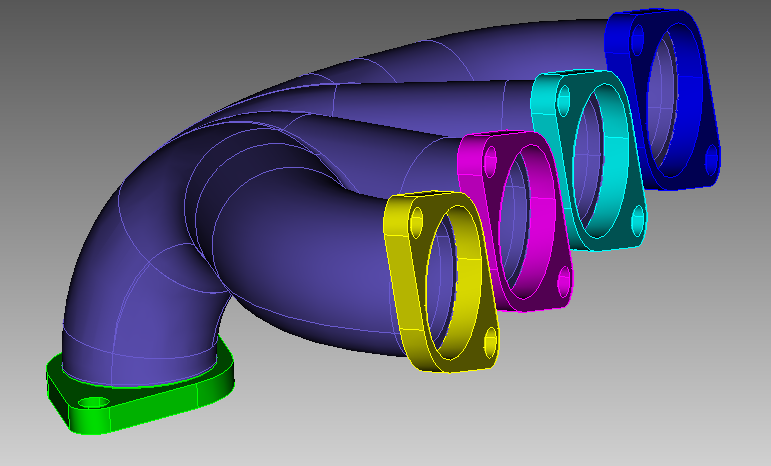

In [3]:
Image("./images/manifold-cad.png", width=800)

This is a nice example of a model which would be extremely difficult to model using CSG. To get started, we'll need two files: 
  1. the DAGMC gometry file on which we'll track particles and 
  2. a tetrahedral mesh of the piping structure on which we'll score tallies
  
To start, let's create the materials we'll need for this problem. The pipes are steel and we'll model the surrounding area as air.

In [4]:
air = openmc.Material(name='air')
air.set_density('g/cc', 0.001205)
air.add_element('N', 0.784431)
air.add_element('O', 0.210748)
air.add_element('Ar',0.0046)

steel = openmc.Material(name='steel')
steel.set_density('g/cc', 8.0)
steel.add_element('Si', 0.010048)
steel.add_element('S', 0.00023)
steel.add_element('Fe', 0.669)
steel.add_element('Ni', 0.12)
steel.add_element('Mo', 0.025)
steel.add_nuclide('P31',0.00023)
steel.add_nuclide('Mn55',0.011014)

materials = openmc.Materials([air, steel])
materials.export_to_xml()

Now let's download the geometry and mesh files.
(This may take some time.)

In [5]:
# get the manifold DAGMC geometry file
download(manifold_geom_url, 'dagmc.h5m') 
# get the manifold tet mesh
download(manifold_mesh_url, 'manifold.h5m')

'Downloading manifold.h5m: 100.0%'

Next we'll create a 5 MeV neutron point source at the entrance the single pipe on the low side of the model with 

In [6]:
src_pnt = openmc.stats.Point(xyz=(0.0, 0.0, 0.0))
src_energy = openmc.stats.Discrete(x=[5.e+06], p=[1.0])

source = openmc.IndependentSource(space=src_pnt, energy=src_energy)

settings = openmc.Settings()
settings.source = source

settings.run_mode = "fixed source"
settings.batches = 10
settings.particles = 100
settings.export_to_xml()

Next we'll apply the DAGMC model as the root universe of the geometry.

In [7]:
dagmc_univ = openmc.DAGMCUniverse(filename='dagmc.h5m')
geometry = openmc.Geometry(root=dagmc_univ)
geometry.export_to_xml()

We'll run a few particles through this geometry to make sure everything is working properly.

In [8]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Now let's setup the unstructured mesh tally. We'll do this the same way we did in the [previous notebook](./unstructured-mesh-part-i.ipynb).

In [9]:
unstructured_mesh = openmc.UnstructuredMesh("manifold.h5m", library='moab')
unstructured_mesh.output = False

mesh_filter = openmc.MeshFilter(unstructured_mesh)

tally = openmc.Tally()
tally.filters = [mesh_filter]
tally.scores = ['flux']
tally.estimator = 'tracklength'

tallies = openmc.Tallies([tally])
tallies.export_to_xml()

In [10]:
settings.batches = 200
settings.particles = 5000
settings.export_to_xml()

In [11]:
openmc.run(output=False)

For the purpose of this example, we haven't run enough particles to score in all of the tet elements, but we indeed see larger flux values near the source location at the bottom of the model.

## Visualization with statepoint data

It was mentioned in the previous unstructured mesh example that the centroids and volumes of elements are written to the state point file. Here, we'll explore how to use that information to produce point cloud information for visualization of this data.

This is particularly important when combining an unstructured mesh tally with other filters as a `.vtk` file will not automatically be written with the statepoint file in that scenario. To demonstrate this, let's setup a tally similar to the one above, but add an energy filter and re-run the model.

In [13]:
# energy filter with bins from 0 to 1 MeV and 1 MeV to 5 MeV
energy_filter = openmc.EnergyFilter((0.0, 1.e+06, 5.e+06))

tally.filters = [mesh_filter, energy_filter]
print(tally)
print(energy_filter)
tallies.export_to_xml()

Tally
	ID             =	1
	Name           =	
	Filters        =	MeshFilter, EnergyFilter
	Nuclides       =	
	Scores         =	['flux']
	Estimator      =	tracklength
EnergyFilter
	Values         =	[      0. 1000000. 5000000.]
	ID             =	2



In [14]:
!cat tallies.xml

<?xml version='1.0' encoding='utf-8'?>
<tallies>
  <mesh id="1" library="moab" type="unstructured">
    <filename>manifold.h5m</filename>
  </mesh>
  <filter id="1" type="mesh">
    <bins>1</bins>
  </filter>
  <filter id="2" type="energy">
    <bins>0.0 1000000.0 5000000.0</bins>
  </filter>
  <tally id="1">
    <filters>1 2</filters>
    <scores>flux</scores>
    <estimator>tracklength</estimator>
  </tally>
</tallies>


In [15]:
openmc.run(output=False)

Noice the warning at the end of the output above indicating that the .vtk file we used before isn't written in this case.

Let's open up this statepoint file and get the information we need to create the point cloud data instead.

_**NOTE: You will need the Python vtk module installed to run this part of the notebook.**_

In [16]:
with openmc.StatePoint("statepoint.200.h5") as sp:
    tally = sp.tallies[1]
    
    umesh = sp.meshes[1]
    centroids = umesh.centroids
    mesh_vols = umesh.volumes
    
    thermal_flux = tally.get_values(scores=['flux'], 
                                    filters=[openmc.EnergyFilter],
                                    filter_bins=[((0.0, 1.e+06),)])
    fast_flux = tally.get_values(scores=['flux'],
                                 filters=[openmc.EnergyFilter],
                                 filter_bins=[((1.e+06, 5.e+06),)])

In [17]:
# reshape the flux data to match that of the mesh dimensions
# unstructured mesh dimensions are always (n_elements,)
mesh_shape = (umesh.n_elements,)
thermal_flux = thermal_flux.reshape(mesh_shape)
fast_flux = fast_flux.reshape(mesh_shape)

In [21]:
data_dict = {'Flux 0 - 1 MeV' : thermal_flux,
             'Flux 1 - 5 MeV' : fast_flux,
             'Total Flux' : thermal_flux + fast_flux}

umesh.write_data_to_vtk("manifold.vtk", data_dict)

We should now see our new flux file in the directory. It can be used to visualize the results in the same way as our other `.vtk` files.

In [22]:
!ls *.vtk

manifold.vtk


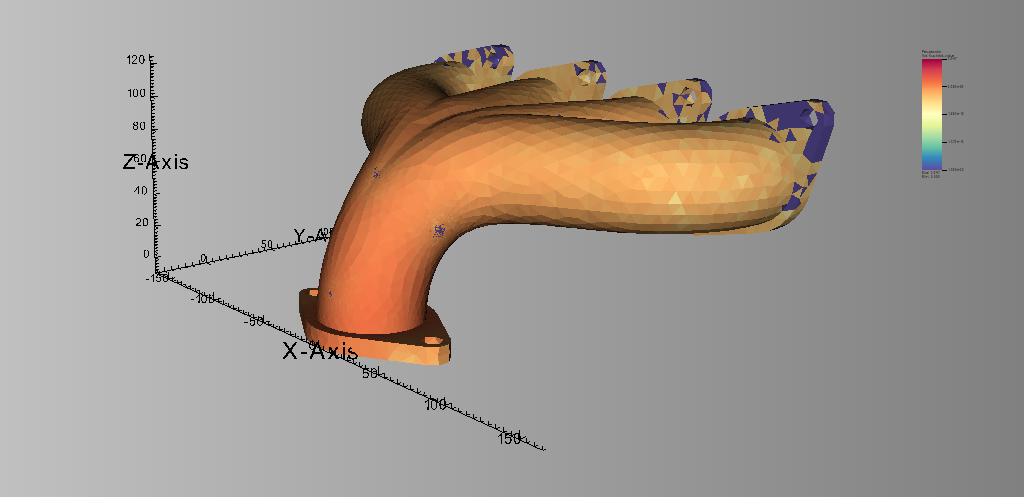

In [23]:
Image("./images/manifold_flux.png", width="800")